<a href="https://colab.research.google.com/github/sridevibonthu/NVIDIA/blob/main/FDPDay4/FinetuningBERTwithfreezing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
print("--- Section 1: Installing required packages ---")
!pip install torch datasets transformers scikit-learn accelerate pandas seaborn matplotlib -q
print("Installation complete.\n")

--- Section 1: Installing required packages ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:

In [ ]:
import torch
import torch.nn as nn
# Import AdamW from transformers
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
# Import the specific BERT model for sequence classification and the tokenizer
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print("Imports complete.\n")

Imports complete.



In [ ]:
# Start timer to track execution time.
start_time = time.time()

# Set device to GPU (cuda) if available, otherwise use CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Configuration parameters
MODEL_NAME = "bert-base-uncased" # Use BERT pre-trained weights and tokenizer
DATASET_NAME = "ag_news"
MAX_LENGTH = 128 # Max sequence length for tokenizer
BATCH_SIZE = 32 # Reduced batch size for BERT on Colab
LEARNING_RATE = 2e-5 # Lower learning rate is common for fine-tuning BERT
EPOCHS = 2 # Reduced epochs as BERT fine-tuning converges faster (and saves time)
TRAIN_SUBSET_SIZE = 10000 # Use a subset for faster training
TEST_SUBSET_SIZE = 1000 # Use a subset for faster evaluation

print("Setup complete.\n")
print(f"NOTE: Using BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}, LR={LEARNING_RATE} for BERT fine-tuning.")

Setup complete.

NOTE: Using BATCH_SIZE=32, EPOCHS=2, LR=2e-05 for BERT fine-tuning.


In [ ]:
# Load subsets of the train and test splits
dataset = load_dataset(DATASET_NAME, split={
    'train': f'train[:{TRAIN_SUBSET_SIZE}]',
    'test': f'test[:{TEST_SUBSET_SIZE}]'
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Define the mapping from label index to label name
# AG News class labels: 0: World, 1: Sports, 2: Business, 3: Sci/Tech
label_map = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
num_classes = len(dataset['train'].unique("label"))

print(f"Dataset loaded.")
print(f"Number of training examples: {len(dataset['train'])}")
print(f"Number of test examples: {len(dataset['test'])}")
print(f"Number of classes: {num_classes}")
print(f"Class labels: {label_map}\n")

Dataset loaded.
Number of training examples: 10000
Number of test examples: 1000
Number of classes: 4
Class labels: {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}



In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer loaded.")

Tokenizer loaded.


In [ ]:
print("--- Section 8: Preprocessing Dataset ---")
# Define a function to tokenize the text data.
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

# Apply the preprocessing function to the dataset.
print("Applying tokenization to the dataset...")
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Rename 'label' to 'labels' for Hugging Face model compatibility
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# Set the format to PyTorch tensors for columns needed by the model.
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


# Separate the processed train and test sets
train_dataset = encoded_dataset['train']
test_dataset = encoded_dataset['test']
print("Preprocessing complete. Dataset formatted for PyTorch.")
# Check column names:
print(f"Train dataset columns: {train_dataset.column_names}")
print(f"Test dataset columns: {test_dataset.column_names}")
print("\n")

--- Section 8: Preprocessing Dataset ---
Applying tokenization to the dataset...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Preprocessing complete. Dataset formatted for PyTorch.
Train dataset columns: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']
Test dataset columns: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']




In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# For evaluation, keep the same structure for simplicity
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
print(f"DataLoaders created with batch size {BATCH_SIZE}.")
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")
print("\n")

DataLoaders created with batch size 32.
Number of batches in train_dataloader: 313
Number of batches in test_dataloader: 32




In [ ]:
# Load the BertForSequenceClassification model
# - MODEL_NAME specifies the BERT variant (bert-base-uncased)
# - num_labels tells the model how many output classes the classification head should have.
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes
)

# Total 12 layers in bert-base-uncased → keep top 3 trainable (layers 9, 10, 11)
for name, param in model.bert.named_parameters():
    if name.startswith("encoder.layer."):
        layer_num = int(name.split(".")[2])
        if layer_num < 9:
            param.requires_grad = False

# Move the model to the designated device
model.to(device)

print(f"Loaded '{MODEL_NAME}' for sequence classification with {num_classes} labels.")
print("The final classification layer weights are randomly initialized and need fine-tuning.\n")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded 'bert-base-uncased' for sequence classification with 4 labels.
The final classification layer weights are randomly initialized and need fine-tuning.



In [ ]:
# Define the optimizer (AdamW recommended for Transformers)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

print("Optimizer (AdamW) instantiated.")

Optimizer (AdamW) instantiated.


In [ ]:
# Print the model structure - this will be quite long!
print(model)

# Calculate and print the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")
print("Note: Most parameters are in the BERT layers (embeddings, encoders).")
print("      The 'classifier' layer at the end is the fine-tuning head.\n")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
model.train() # Set the model to training mode

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    epoch_loss = 0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Iterate over batches in the training data loader
    for i, batch in enumerate(train_dataloader):
        # Move batch data to the configured device
        batch = {k: v.to(device) for k, v in batch.items()}

        # 1. Zero gradients
        optimizer.zero_grad()

        # 2. Forward pass: Pass the batch directly to the model.
        # Since 'labels' are in the batch, the model calculates the loss internally.
        outputs = model(**batch)

        # 3. Get the loss from the model output
        loss = outputs.loss

        # 4. Backward pass: Compute gradients
        loss.backward()

        # 5. Optimizer step: Update model weights
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

        # Print progress periodically
        if (i + 1) % 20 == 0: # Print more frequently if needed
             print(f"  Batch {i+1}/{len(train_dataloader)}, Batch Loss: {loss.item():.4f}")

    # Calculate and print average loss for the epoch
    epoch_end_time = time.time()
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")
    print(f"Average Training Loss: {avg_epoch_loss:.4f}")

print("\n--- Training Finished ---")


Epoch 1/2
  Batch 20/313, Batch Loss: 1.0909
  Batch 40/313, Batch Loss: 0.7371
  Batch 60/313, Batch Loss: 0.4978
  Batch 80/313, Batch Loss: 0.6271
  Batch 100/313, Batch Loss: 0.1966
  Batch 120/313, Batch Loss: 0.3389
  Batch 140/313, Batch Loss: 0.6495
  Batch 160/313, Batch Loss: 0.4108
  Batch 180/313, Batch Loss: 0.4319
  Batch 200/313, Batch Loss: 0.3172
  Batch 220/313, Batch Loss: 0.5764
  Batch 240/313, Batch Loss: 0.3431
  Batch 260/313, Batch Loss: 0.0867
  Batch 280/313, Batch Loss: 0.3383
  Batch 300/313, Batch Loss: 0.3239
Epoch 1 completed in 148.42 seconds.
Average Training Loss: 0.4721

Epoch 2/2
  Batch 20/313, Batch Loss: 0.3002
  Batch 40/313, Batch Loss: 0.3494
  Batch 60/313, Batch Loss: 0.3705
  Batch 80/313, Batch Loss: 0.2210
  Batch 100/313, Batch Loss: 0.1450
  Batch 120/313, Batch Loss: 0.0920
  Batch 140/313, Batch Loss: 0.2422
  Batch 160/313, Batch Loss: 0.1105
  Batch 180/313, Batch Loss: 0.1533
  Batch 200/313, Batch Loss: 0.3087
  Batch 220/313, Ba


--- Evaluation Results ---
Test Accuracy: 0.9160

Classification Report:
              precision    recall  f1-score   support

       World     0.8986    0.9254    0.9118       268
      Sports     0.9743    0.9672    0.9707       274
    Business     0.8854    0.8293    0.8564       205
    Sci/Tech     0.8962    0.9209    0.9084       253

    accuracy                         0.9160      1000
   macro avg     0.9136    0.9107    0.9118      1000
weighted avg     0.9160    0.9160    0.9157      1000


Confusion Matrix:


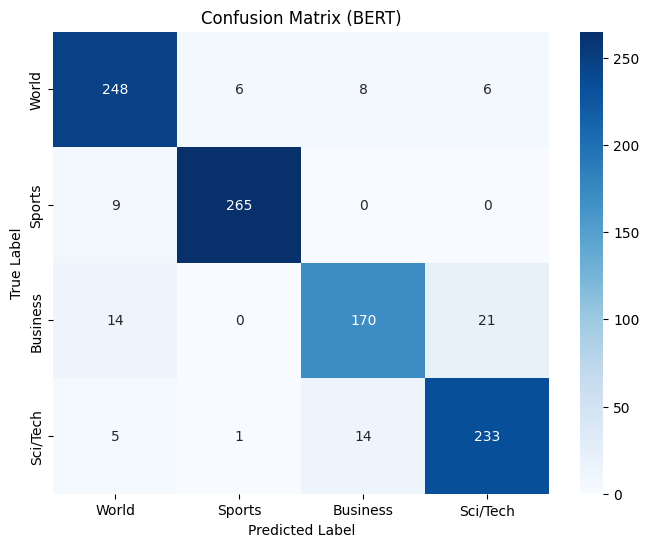


--- Evaluation Finished ---


In [ ]:
model.eval() # Set the model to evaluation mode

all_preds = []
all_labels = []

# Disable gradient calculations
with torch.no_grad():
    # Iterate over batches in the test data loader
    for batch in test_dataloader:
        # Store true labels (on CPU)
        batch_labels = batch['labels'].cpu().numpy()
        all_labels.extend(batch_labels)

        # Move batch data to the device (input_ids, attention_mask)
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        # Forward pass: Get model outputs (logits)
        outputs = model(**batch_inputs)
        logits = outputs.logits

        # Get predictions by finding the class with the highest logit score
        predictions = torch.argmax(logits, dim=1)

        # Move predictions to CPU and store them
        all_preds.extend(predictions.cpu().numpy())


# Calculate metrics using scikit-learn
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=label_map.values(), digits=4)
conf_matrix = confusion_matrix(all_labels, all_preds)

print("\n--- Evaluation Results ---")
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# Plot Confusion Matrix
print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (BERT)')
plt.show()

print("\n--- Evaluation Finished ---")

In [ ]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes).")
print("(Note: Fine-tuning BERT takes significantly longer than the simple model.)\n")

Total execution time: 564.11 seconds (9.40 minutes).
(Note: Fine-tuning BERT takes significantly longer than the simple model.)



In [ ]:
# Define a new sentence
text = "The latest space mission successfully launched yesterday evening."
print(f"Input Sentence: '{text}'")

model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # Disable gradients
    # 1. Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LENGTH)

    # 2. Move tokenized inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 3. Get model output (logits)
    # Pass inputs directly using dictionary unpacking **inputs
    outputs = model(**inputs)
    logits = outputs.logits

    # 4. Get the predicted class index
    prediction_idx = torch.argmax(logits, dim=1).item()

    # 5. Map the predicted index back to the readable label name
    predicted_label = label_map.get(prediction_idx, 'Unknown')

    print(f"Predicted class index: {prediction_idx}")
    print(f"Predicted label: {predicted_label}")
print("\n--- End of Notebook ---")

Input Sentence: 'The latest space mission successfully launched yesterday evening.'
Predicted class index: 3
Predicted label: Sci/Tech

--- End of Notebook ---
